In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mp
import pandas as pd
import numpy as np
import pysam
import pyranges as pr
from scipy import stats
from collections import Counter

In [2]:
# 设置全局字体

import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# load data

In [3]:
# 读取代表性转录本gene_model
araport11_isoform_path = '/public/home/mowp/db/Arabidopsis_thaliana/representative_gene_model/araport11.representative.gene_model.bed'
araport11_isoform = pd.read_csv(araport11_isoform_path, sep='\t', 
                                names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                       'score', 'strand', 'thickStart', 'thickEnd', 
                                       'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
                               )
araport11_isoform['gene_id'] = araport11_isoform['name'].map(lambda x: x.split('.')[0])
araport11_isoform.set_index('gene_id', inplace=True)

In [4]:
# 获取所有 pA site位置
all_pa_path = '/public/home/mowp/data/chromatin_rna/polya_sites/cbRNA.polya_cluster.summit.bed'
all_pa_site = pd.read_csv(
    all_pa_path, sep='\t',
    names=['chrom', 'chromStart', 'chromEnd', 'name',
         'score', 'strand', 'ratio'],
)
all_pa_site['name'] = all_pa_site['name'].map(lambda x: x.split('_')[0])
all_pa_site.set_index('name', inplace=True)

In [5]:
# 获取 last pA site位置
last_pa_path = '/public/home/mowp/data/chromatin_rna/polya_sites/cbRNA.last_polya_cluster_summit.bed'
last_pa_site = pd.read_csv(
    last_pa_path, sep='\t',
    names=['chrom', 'chromStart', 'chromEnd', 'name',
         'score', 'strand', 'ratio'],
)
last_pa_site['name'] = last_pa_site['name'].map(lambda x: x.split('_')[0])
last_pa_site.set_index('name', inplace=True)

In [ ]:
# 根据retention intron 排序
def _sort_bam(self, read_list):
    '''
    if self.strand == '+':
        read_list.sort(key=lambda read: splice_stats_dict[read.query_name][self.gene_id].unsplice_intron)
    else:
        read_list.sort(key=lambda read: splice_stats_dict[read.query_name][self.gene_id].unsplice_intron, reverse=True)
    '''
    if self.strand == '+':
        read_list.sort(key=lambda read: read.reference_end)
    else:
        read_list.sort(key=lambda read: read.reference_start, reverse=True)

# main class

In [155]:
class IGV:
    '''
    IGV(gene_id)
    '''
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self.bam_list = {}

    def _set_plot_range(self, read, polya_len=0):
        if not read.is_reverse and self.max < read.reference_end+polya_len:
            self.max = read.reference_end+int(polya_len)
        elif read.is_reverse and self.min > read.reference_start-polya_len:
            self.min = read.reference_start-int(polya_len)


    def _get_gene_info(self):
        '''
        Get gene info from bed file
        '''
        gene_info = araport11_isoform.loc[self.gene_id]  # araport11_isoform loaded from pandas
        self.chrom = gene_info.chrom
        self.start = gene_info.chromStart
        self.end = gene_info.chromEnd
        self.strand = gene_info.strand
        self.thickStart = gene_info.thickStart
        self.thickEnd = gene_info.thickEnd
        self.blockCount = gene_info.blockCount
        self.strand_boo = False if self.strand == '+' else True
        self.blockSizes = np.fromstring(gene_info.blockSizes, sep=',', dtype='int')
        self.blockStarts = np.fromstring(gene_info.blockStarts, sep=',', dtype='int') + self.start # 0 base

    def _plot_gene_model(self, ax, gene_color='k'):
        # 画转录起始位点及方向箭头
        small_relative = 0.05 * (self.end-self.start)  # 箭头突出部分相对长度
        arrowprops = dict(arrowstyle="-|>", connectionstyle="angle", color=gene_color)
        if self.strand == '+':
            ax.annotate('', xy=(self.start+small_relative, .6), xytext=(self.start, 0), arrowprops=arrowprops)
        else:
            ax.annotate('', xy=(self.end-small_relative, .6), xytext=(self.end, 0), arrowprops=arrowprops)
        ax.plot([self.start, self.end], [0, 0], color=gene_color)  # 基因有多长这条线就有多长

        height = .3 # gene model 高度

        for exonstart, size in zip(self.blockStarts, self.blockSizes):
            if exonstart == self.start and exonstart+size == self.end:
                utr_size = self.thickStart-self.start
                utr = mp.Rectangle((exonstart, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                utr_size = self.end-self.thickEnd
                utr = mp.Rectangle((self.thickEnd, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                exon = mp.Rectangle((self.thickStart, 0-height), self.thickEnd-self.thickStart, height*2, color=gene_color, linewidth=0)
                ax.add_patch(exon)
            elif exonstart + size <= self.thickStart:
                # 只有5'/ 3'UTR
                utr = mp.Rectangle((exonstart, 0-height/2), size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
            elif exonstart < self.thickStart and exonstart + size > self.thickStart:
                # 带有5' / 3' UTR的exon
                utr_size = self.thickStart-exonstart
                utr = mp.Rectangle((exonstart, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                exon = mp.Rectangle((exonstart+utr_size, 0-height), size-utr_size, height*2, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                ax.add_patch(exon)
            elif exonstart >= self.thickStart and exonstart + size <= self.thickEnd:
                # 普通exon
                exon = mp.Rectangle((exonstart, 0-height), size, height*2, color=gene_color, linewidth=0)
                ax.add_patch(exon)
            elif exonstart < self.thickEnd and exonstart + size > self.thickEnd:
                # 带有3' / 5' UTR的exon
                utr_size = exonstart + size - self.thickEnd
                utr = mp.Rectangle((self.thickEnd, 0-height/2), utr_size, height, color=gene_color, linewidth=0)
                exon = mp.Rectangle((exonstart, 0-height), size-utr_size, height*2, color=gene_color, linewidth=0)
                ax.add_patch(utr)
                ax.add_patch(exon)
            elif exonstart >= self.thickEnd:
                # 只有3'/ 5'UTR
                utr = mp.Rectangle((exonstart, 0-height/2), size, height, color=gene_color, linewidth=0)
                ax.add_patch(utr)
            
        ax.annotate(s=self.gene_id, xy=((self.start+self.end)/2, 0.8), ha='center')
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_ticks_position('none')
        ax.set_ylim(-.5, 1)
        
        
    def _find_exon(self, read):
        BAM_CREF_SKIP = 3 #BAM_CREF_SKIP
        blockStart = []
        blockSize = []
        match_or_deletion = {0, 2, 7, 8} # only M/=/X (0/7/8) and D (2) are related to genome position
        exon_start = read.reference_start
        length = 0
        for op, nt in read.cigartuples:
            if op in match_or_deletion:
                length += nt
            elif op == BAM_CREF_SKIP:
                blockStart.append(exon_start)
                blockSize.append(length)
                exon_start += length+nt
                length = 0
        blockStart.append(exon_start)
        blockSize.append(length)
        return zip(blockStart, blockSize)
        
    def _plot_bam(self, ax, read_list, bam_num, read_color='#5D93C4', polya_color='lightcoral'):
        ypos = 0
        height = .6
        n = 0
        for read in read_list:
            polya_len = read.get_tag('pa')
            if polya_len > self.polya_len_threshold:
                continue
            n += 1

            line = mp.Rectangle((read.reference_start, ypos-height/4), read.reference_length, height/2, color='#A6A6A6', linewidth=0)
            ax.add_patch(line)
            for block_start, block_size in self._find_exon(read):
                exon = mp.Rectangle((block_start, ypos-height), block_size, height*2, color=read_color, linewidth=0)
                ax.add_patch(exon)

            # 画polya尾巴
            if self.plot_polya and polya_len > 15:
                if self.strand == '+':
                    polya_tail = mp.Rectangle((block_start+block_size, ypos-height), polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
                else:
                    polya_tail = mp.Rectangle((read.reference_start, ypos-height), -polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
            ypos += -1

        #step = (self.end-self.start)//400*100  # 坐标轴步长
        step = (self.max-self.min)//400*100  # 坐标轴步长

        if self.strand == '+':
            #xticks = np.arange(self.start, self.end+step, step)
            xticks = np.arange(self.start, self.max+step, step)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
        else:
            #xticks = np.arange(self.end, self.start-step, -step)
            xticks = np.arange(self.end, self.min-step, -step)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
            ax.invert_xaxis()

        
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.set_ylim(ypos-int(len(read_list)*.1), 1+int(len(read_list)*.1))
        ax.set_xlabel('Length (nt)')

        print(n)

    def _filter_reads(self, read, five_prime_threshold=150):
        # 过滤read方向不一致的read
        if read.is_reverse is not self.strand_boo:
            return True
        # 过滤上游基因reads
        if read.is_reverse and read.reference_end-self.end > five_prime_threshold:
            return True
        elif not read.is_reverse and self.start - read.reference_start > five_prime_threshold:
            return True

        return False

    def _sort_bam(self, read_list, sortby='five'):
#         if self.strand == '+':
#             read_list.sort(key=lambda read: read.reference_end)
#         else:
#             read_list.sort(key=lambda read: read.reference_start, reverse=True)
        if sortby == 'five':
            if self.strand == '+':
                read_list.sort(key=lambda read: read.reference_start)
            else:
                read_list.sort(key=lambda read: read.reference_end, reverse=True)
        elif sortby == 'three':
            if self.strand == '+':
                read_list.sort(key=lambda read: read.reference_end)
            else:
                read_list.sort(key=lambda read: read.reference_start, reverse=True)

    def zscore_treatment(self, data):
        '''
        根据zscore去除异常值 (threshold=3)
        返回最大值
        '''
        data = np.array(data)
        z = np.abs(stats.zscore(data))
        return data[z<=3].max()


    def add_bam(self, *bam_paths, plot_polya=False, sortby='five'):
        '''
        Input:
            A list of bam files
            eg. add_bam('a.bam', 'b.bam')
        '''
        self.plot_polya = plot_polya
        polya_len_list = []
        for bam_path in bam_paths:
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                polya_read, non_polya_read = [], []
                '''
                向基因下游延申1000nt
                不能超过染色体范围
                '''
                if self.strand == '-':
                    start = self.start-1000 if self.start > 1000 else 1
                    end = self.end
                else:
                    end = self.end+1000 if self.end+1000 < inbam.get_reference_length(self.chrom) else inbam.get_reference_length(self.chrom)
                    start = self.start
                    
                for read in inbam.fetch(self.chrom, start, end):
                    # 过滤read
                    if self._filter_reads(read):
                        continue

                    polya_len = read.get_tag('pa')
                    gap = read.get_tag('ga')
                    read_gene_id = read.get_tag('gi')
                    if read_gene_id not in {gene_id, 'None'}:
                        continue
                    
                    if plot_polya and polya_len > 15:
                        polya_read.append(read)
                    elif gap < 5 and polya_len < 15:
                        non_polya_read.append(read)

                    polya_len_list.append(polya_len)
            # 按照3'end排序
            self._sort_bam(polya_read, sortby=sortby)
            self._sort_bam(non_polya_read, sortby=sortby)
            # 合并
            non_polya_read.extend(polya_read)
            self.bam_list[bam_path] = non_polya_read

            self.polya_len_threshold = self.zscore_treatment(polya_len_list)

        for bam_path in bam_paths:
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                for read in inbam.fetch(self.chrom, start, end):
                    if polya_len < self.polya_len_threshold:
                        self._set_plot_range(read, polya_len)
                        
                        
    def plot(self, height, width):
        nrows = len(self.bam_list)+1
        height_ratios = [.6]
        for bam_path in self.bam_list:
            if height == 'auto':
                height_ratios.append(len(self.bam_list[bam_path])*.02)
            else:
                height_ratios.append(height)

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(width, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        if len(self.bam_list) == 0:
            self._plot_gene_model(ax)
        else:
            self._plot_gene_model(ax[0])

        # plot bam files
        for i, bam_path in enumerate(self.bam_list, 1):
            self._plot_bam(ax[i], self.bam_list[bam_path], i)
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'igv_plot/{self.gene_id}.igv.svg', format='svg', bbox_inches='tight')

In [8]:
class IGV_pa(IGV):
    '''
    add pA sites to the igv plot
    '''
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self._get_pa_site()
        self.bam_list = {}
    
    def _get_pa_site(self):
        try:
            try:
                self.pa_sites = all_pa_site.loc[self.gene_id, 'chromStart'].values
            except AttributeError:
                self.pa_sites = [all_pa_site.loc[self.gene_id, 'chromStart']]
        except KeyError:
            self.pa_sites = None
    
    def _plot_pa(self, ax):
        for pa_site in self.pa_sites:
            ax.axvline(pa_site, ls='--', color='#555555', lw=1)
    
    def plot(self, height='auto'):
        nrows = len(self.bam_list)+1
        height_ratios = [.6]
        for bam_path in self.bam_list:
            if height == 'auto':
                height_ratios.append(len(self.bam_list[bam_path])*.02)
            else:
                height_ratios.append(height)

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(10, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        self._plot_gene_model(ax[0])

        # plot bam files
        for i, bam_path in enumerate(self.bam_list, 1):
            self._plot_pa(ax[i])
            self._plot_bam(ax[i], self.bam_list[bam_path])
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'{self.gene_id}.igv_pa.svg', format='svg', bbox_inches='tight')    


# transcript categry

In [10]:
# 2020.10.20 update

class IGV_transcript_categry(IGV):
    '''
    画不同类型的转录本
    '''
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self._get_pa_site()
        self.bam_list = {}
        self.bam_num = 0
    
    def _get_pa_site(self):
        try:
            try:
                self.pa_sites = all_pa_site.loc[self.gene_id, 'chromStart'].values
            except AttributeError:
                self.pa_sites = [all_pa_site.loc[self.gene_id, 'chromStart']]
        except KeyError:
            self.pa_sites = None
    
    def _plot_pa(self, ax):
        for pa_site in self.pa_sites:
            ax.axvline(pa_site, ls='--', color='#555555', lw=1)
            ax.axvspan(pa_site-24, pa_site+24, color='#555555', alpha=0.2)

    def _plot_bam(self, ax, read_list, bam_num, read_color='#5D93C4', polya_color='lightcoral'):
        ypos = 0
        height = .4
        for read in read_list:
            if read is None:
                ypos += -int(len(read_list)*.08)
                continue
            line = mp.Rectangle((read.reference_start, ypos-height/4), read.reference_length, height/2, color='#A6A6A6', linewidth=0)
            ax.add_patch(line)
            #read_color = read.get_tag('co')
            for block_start, block_size in self._find_exon(read):
                exon = mp.Rectangle((block_start, ypos-height), block_size, height*2, color=read_color, linewidth=0)
                ax.add_patch(exon)
            # 画polya尾巴
            polya_len = read.get_tag('pa')
            if self.plot_polya and polya_len > 15:
                if self.strand == '+':
                    polya_tail = mp.Rectangle((block_start+block_size, ypos-height), polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
                else:
                    polya_tail = mp.Rectangle((read.reference_start, ypos-height), -polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
            ypos += -1

        #step = (self.end-self.start)//400*100  # 坐标轴步长
        step = (self.max-self.min)//400*100  # 坐标轴步长

        if self.strand == '+':
            #xticks = np.arange(self.start, self.end+step, step)
            xticks = np.arange(self.start, self.max+step, step)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
        else:
            #xticks = np.arange(self.end, self.start-step, -step)
            xticks = np.arange(self.end, self.min-step, -step)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
            ax.invert_xaxis()

        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        if bam_num != self.bam_num:
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_ticks_position('none')
        else:
            ax.set_xlabel('Length (nt)')
        
        ax.set_ylim(ypos-int(len(read_list)*.3), 1+int(len(read_list)*.8))
        
    
    def plot(self, height=1, width=5):
        nrows = self.bam_num+1
        height_ratios = [.6]+[height]*self.bam_num

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(width, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        self._plot_gene_model(ax[0])

        # plot bam files
        i = 1
        for bam_path in self.bam_list:
            for bam_reads in self.bam_list[bam_path]:
                self._plot_pa(ax[i])
                self._plot_bam(ax[i], bam_reads, i)
                i += 1
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'{self.gene_id}.transcript_cata.svg', format='svg', bbox_inches='tight')
    
    def add_bam(self, *bam_paths, plot_polya=True, extend=1000):
        '''
        Input:
            A list of bam files
            eg. add_bam('a.bam', 'b.bam')
        '''
        results = []
        self.plot_polya = plot_polya
        #results = [None]
        for bam_path in bam_paths:
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                transcript_categries = {
                    'elongating': [],
                    'uncleavaged_readthrough': [],
                    'cleavaged': [],
                    'cleavaged_readthrough': [],
                    'polyadenylated': [],
                    }   # 以字典形式放不同类型的转录本reads
                '''
                向基因下游延申1000nt
                不能超过染色体范围
                '''
                if self.strand == '-':
                    start = self.start-extend if self.start > extend else 1
                    end = self.end
                else:
                    end = self.end+extend if self.end+extend < inbam.get_reference_length(self.chrom) else inbam.get_reference_length(self.chrom)
                    start = self.start
                    
                for read in inbam.fetch(self.chrom, start, end):
                    # 过滤read
                    if self._filter_reads(read):
                        continue

                    polya_len = read.get_tag('pa')
                    gap = read.get_tag('ga')
                    read_gene_id = read.get_tag('gi')
                    if read_gene_id not in {gene_id, 'None'}:
                        continue
                    
                    
                    if plot_polya and polya_len > 15:
                        transcript_categries['polyadenylated'].append(read)
                        self._set_plot_range(read, polya_len)
                    elif polya_len < 15 and gap < 5:
                        self._set_plot_range(read)

                        if self.strand == '-':
                            five_end = read.reference_end*-1
                            three_end = read.reference_start*-1
                            pa_site = last_pa_site.at[gene_id, 'chromEnd']*-1
                        else:
                            five_end = read.reference_start
                            three_end = read.reference_end
                            pa_site = last_pa_site.at[gene_id, 'chromEnd']

                        
                        if five_end >= pa_site:
                            transcript_categries['cleavaged_readthrough'].append(read)
                        elif three_end < pa_site-24:
                            transcript_categries['elongating'].append(read)
                        elif three_end > pa_site+24:
                            transcript_categries['uncleavaged_readthrough'].append(read)
                        elif pa_site-24 <= three_end <= pa_site+24:
                            transcript_categries['cleavaged'].append(read)
                
            # 按照3'end排序 + 合并
            for read_type in transcript_categries:
                self._sort_bam(transcript_categries[read_type])
                results.append(transcript_categries[read_type])
                self.bam_num += 1
            
            self.bam_list[bam_path] = results


/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: user 20.6 s, sys: 931 ms, total: 21.5 s
Wall time: 20.4 s


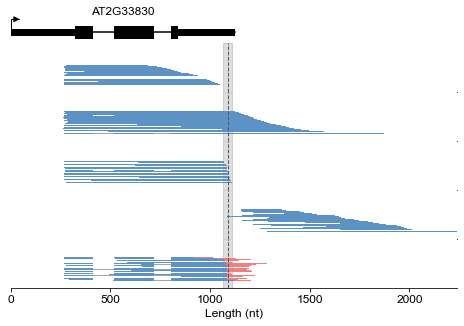

In [12]:
%%time

# WT

gene_id = 'AT2G33830'
wt_bam_file = '/public/home/mowp/data/cbRNA_3/aligned_data/cb3.adjust.sorted.tagged.bam'
igv = IGV_transcript_categry(gene_id)
igv.add_bam(wt_bam_file, plot_polya=True)
igv.plot(height=.9, width=8)

In [114]:
for bam_file in igv.bam_list:
    for intermediate in igv.bam_list[bam_file]:
        print(len(intermediate))

441
361
54
35
983


/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator


279
103
CPU times: user 11.3 s, sys: 67.1 ms, total: 11.4 s
Wall time: 11.4 s


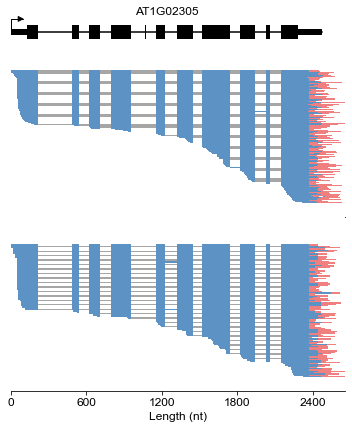

In [78]:
%%time


gene_id = 'AT1G61520'
gene_id = 'AT1G01920'
gene_id = 'AT1G02205'
gene_id = 'AT1G02305'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'
pacbio = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.add_bam(pacbio, plot_polya=True)
igv.plot(height=3.2, width=6)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator


246
CPU times: user 5.89 s, sys: 87.3 ms, total: 5.97 s
Wall time: 5.92 s


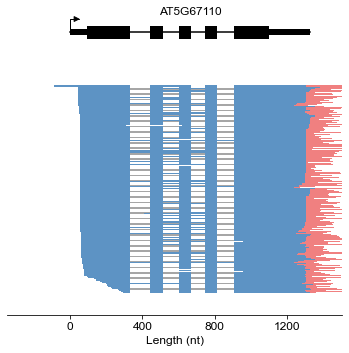

In [86]:
%%time

gene_id = 'AT5G67110'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.plot(height=5, width=6)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator


111
CPU times: user 1.75 s, sys: 15 ms, total: 1.76 s
Wall time: 1.76 s


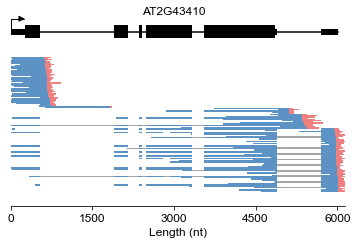

In [169]:
%%time

gene_id = 'AT2G43410'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore, plot_polya=True, sortby='three')
igv.plot(height=3, width=6)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator


427
CPU times: user 9.91 s, sys: 78.4 ms, total: 9.99 s
Wall time: 10.1 s


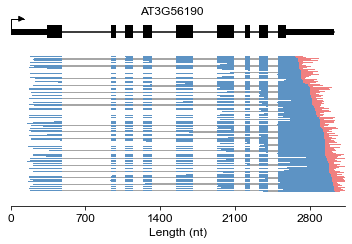

In [222]:
%%time

gene_id = 'AT3G56190'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'
igv = IGV(gene_id)
igv.add_bam(nanopore, plot_polya=True, sortby='three')
igv.plot(height=3, width=6)

# IGV for IR

In [89]:
from collections import defaultdict, namedtuple, Counter
import pickle

Splice_stats = namedtuple('Splice_stats', 'intron_total_count intron_count unsplice_count unsplice_intron')

splice_stats_pkl = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bed.splice_stats.tsv'

with open(splice_stats_pkl+'.pkl', 'rb') as f:
    splice_stats_dict = pickle.load(f)

In [92]:
class IGV_splicing(IGV):
    def _sort_bam(self, read_list):
        if self.strand == '+':
            read_list.sort(key=lambda read: splice_stats_dict[read.query_name][self.gene_id].unsplice_intron)
        else:
            read_list.sort(key=lambda read: splice_stats_dict[read.query_name][self.gene_id].unsplice_intron, reverse=True)

In [119]:
class IGV_splicing(IGV):
    '''
    splice_stats_dict={
        '7630665e-c2ca-4b8d-a6d7-2240d68f8844':
            {'AT1G01010': Splice_stats(intron_total_count=5, intron_count=5, unsplice_count=0, unsplice_intron='')}，
    }
    '''
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self.bam_list = {}
        self.bam_num = 0
        
    def _sort_bam(self, read_list):
        if self.strand == '+':
            read_list.sort(key=lambda read: splice_stats_dict[read.query_name][self.gene_id].unsplice_intron)
        else:
            read_list.sort(key=lambda read: splice_stats_dict[read.query_name][self.gene_id].unsplice_intron, reverse=True)
    
    def add_bam(self, *bam_paths, plot_polya=False):
        '''
        Input:
            A list of bam files
            eg. add_bam('a.bam', 'b.bam')
        '''
        self.plot_polya = plot_polya
        for bam_path in bam_paths:
            polya_len_list = []
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                transcript_categries = {
                    'spliced': [],
                    'IR': [],
                    }   # 以字典形式放不同类型的转录本reads
                polya_read, non_polya_read = [], []
                '''
                向基因下游延申1000nt
                不能超过染色体范围
                '''
                if self.strand == '-':
                    start = self.start-1000 if self.start > 1000 else 1
                    end = self.end
                else:
                    end = self.end+1000 if self.end+1000 < inbam.get_reference_length(self.chrom) else inbam.get_reference_length(self.chrom)
                    start = self.start
                    
                for read in inbam.fetch(self.chrom, start, end):
                    # 过滤read
                    if self._filter_reads(read):
                        continue

                    polya_len = read.get_tag('pa')
                    read_gene_id = read.get_tag('gi')
                    if read_gene_id not in {gene_id, 'None'}:
                        continue
                    self._set_plot_range(read, polya_len)
                    
                    if splice_stats_dict[read.query_name][self.gene_id].unsplice_count == 0:
                        transcript_categries['spliced'].append(read)
                    else:
                        transcript_categries['IR'].append(read)

                    polya_len_list.append(polya_len)

            results = []
            for read_type in transcript_categries:
                self._sort_bam(transcript_categries[read_type])
                results.append(transcript_categries[read_type])
                self.bam_num += 1
            
            self.bam_list[bam_path] = results


    def _plot_bam(self, ax, read_list, bam_num, read_color='#5D93C4', polya_color='lightcoral'):
        ypos = 0
        height = .4
        for read in read_list:
            if read is None:
                ypos += -int(len(read_list)*.08)
                continue
            line = mp.Rectangle((read.reference_start, ypos-height/4), read.reference_length, height/2, color='#A6A6A6', linewidth=0)
            ax.add_patch(line)
            #read_color = read.get_tag('co')
            for block_start, block_size in self._find_exon(read):
                exon = mp.Rectangle((block_start, ypos-height), block_size, height*2, color=read_color, linewidth=0)
                ax.add_patch(exon)
            # 画polya尾巴
            polya_len = read.get_tag('pa')
            if self.plot_polya and polya_len > 15:
                if self.strand == '+':
                    polya_tail = mp.Rectangle((block_start+block_size, ypos-height), polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
                else:
                    polya_tail = mp.Rectangle((read.reference_start, ypos-height), -polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
            ypos += -1

        #step = (self.end-self.start)//400*100  # 坐标轴步长
        step = (self.max-self.min)//400*100  # 坐标轴步长

        if self.strand == '+':
            #xticks = np.arange(self.start, self.end+step, step)
            xticks = np.arange(self.start, self.max+step, step)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
        else:
            #xticks = np.arange(self.end, self.start-step, -step)
            xticks = np.arange(self.end, self.min-step, -step)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
            ax.invert_xaxis()

        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        if bam_num != self.bam_num:
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_ticks_position('none')
        else:
            ax.set_xlabel('Length (nt)')
        
        ax.set_ylim(ypos-int(len(read_list)*.1), 1+int(len(read_list)*.2))
        
    
    def plot(self, height=1, width=5):
        nrows = self.bam_num+1
        height_ratios = [.6]+[height]*self.bam_num

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(width, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        self._plot_gene_model(ax[0])

        # plot bam files
        i = 1
        for bam_path in self.bam_list:
            for bam_reads in self.bam_list[bam_path]:
                self._plot_bam(ax[i], bam_reads, i)
                i += 1
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'igv_plot/{self.gene_id}.splicing.svg', format='svg', bbox_inches='tight')

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: user 8.19 s, sys: 219 ms, total: 8.41 s
Wall time: 8.38 s


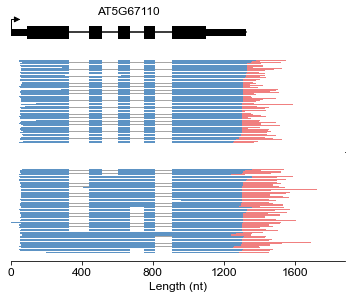

In [122]:
%%time

gene_id = 'AT5G67110'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
igv = IGV_splicing(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.plot(height=2, width=6)

# IGV for ES

In [128]:
from collections import defaultdict, namedtuple, Counter
import pickle

IR_stats = namedtuple('IR_stats', 'intron_total_count intron_count unsplice_count unsplice_intron')

ir_stats_pkl = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bed.ir_stats.tsv'

with open(ir_stats_pkl+'.pkl', 'rb') as f:
    ir_stats_dict = pickle.load(f)

In [124]:
from collections import defaultdict, namedtuple, Counter
import pickle

ES_stats = namedtuple('ES_stats', 'exon_total_count exon_count skipped_exon_count skipped_exon')

es_stats_pkl = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bed.es_stats.tsv.pkl'

with open(es_stats_pkl, 'rb') as f:
    es_stats_dict = pickle.load(f)

In [125]:
class IGV_ES(IGV):
    def _sort_bam(self, read_list):
        if self.strand == '+':
            read_list.sort(key=lambda read: es_stats_dict[read.query_name][self.gene_id].skipped_exon)
        else:
            read_list.sort(key=lambda read: es_stats_dict[read.query_name][self.gene_id].skipped_exon, reverse=True)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:145: UserWarning: FixedFormatter should only be used together with FixedLocator


79
CPU times: user 3.01 s, sys: 31.1 ms, total: 3.04 s
Wall time: 3.02 s


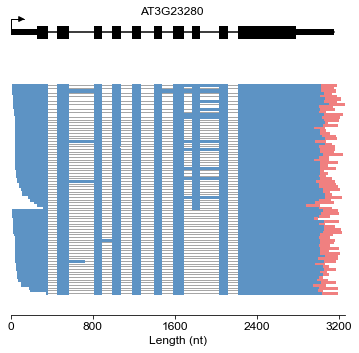

In [126]:
%%time

gene_id = 'AT3G23280'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
igv = IGV_ES(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.plot(height=5, width=6)

In [132]:
class IGV_ES(IGV):
    '''
    splice_stats_dict={
        '7630665e-c2ca-4b8d-a6d7-2240d68f8844':
            {'AT1G01010': Splice_stats(intron_total_count=5, intron_count=5, unsplice_count=0, unsplice_intron='')}，
    }
    '''
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self.bam_list = {}
        self.bam_num = 0
        
    def _sort_bam(self, read_list):
        if self.strand == '+':
            read_list.sort(key=lambda read: es_stats_dict[read.query_name][self.gene_id].skipped_exon)
        else:
            read_list.sort(key=lambda read: es_stats_dict[read.query_name][self.gene_id].skipped_exon, reverse=True)
    
    def add_bam(self, *bam_paths, plot_polya=False):
        '''
        Input:
            A list of bam files
            eg. add_bam('a.bam', 'b.bam')
        '''
        self.plot_polya = plot_polya
        for bam_path in bam_paths:
            polya_len_list = []
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                transcript_categries = {
                    'non-skipping': [],
                    'skipping': [],
                    }   # 以字典形式放不同类型的转录本reads
                polya_read, non_polya_read = [], []
                '''
                向基因下游延申1000nt
                不能超过染色体范围
                '''
                if self.strand == '-':
                    start = self.start-1000 if self.start > 1000 else 1
                    end = self.end
                else:
                    end = self.end+1000 if self.end+1000 < inbam.get_reference_length(self.chrom) else inbam.get_reference_length(self.chrom)
                    start = self.start
                    
                for read in inbam.fetch(self.chrom, start, end):
                    # 过滤read
                    if self._filter_reads(read):
                        continue

                    polya_len = read.get_tag('pa')
                    read_gene_id = read.get_tag('gi')
                    if read_gene_id not in {gene_id, 'None'}:
                        continue
                    
                    if ir_stats_dict[read.query_name][self.gene_id].unsplice_count > 0:
                        continue
                    
                    self._set_plot_range(read, polya_len)
                    if es_stats_dict[read.query_name][self.gene_id].skipped_exon_count == 0:
                        transcript_categries['non-skipping'].append(read)
                    else:
                        transcript_categries['skipping'].append(read)

                    polya_len_list.append(polya_len)

            results = []
            for read_type in transcript_categries:
                self._sort_bam(transcript_categries[read_type])
                results.append(transcript_categries[read_type])
                self.bam_num += 1
            
            self.bam_list[bam_path] = results


    def _plot_bam(self, ax, read_list, bam_num, read_color='#5D93C4', polya_color='lightcoral'):
        ypos = 0
        height = .4
        for read in read_list:
            if read is None:
                ypos += -int(len(read_list)*.08)
                continue
            line = mp.Rectangle((read.reference_start, ypos-height/4), read.reference_length, height/2, color='#A6A6A6', linewidth=0)
            ax.add_patch(line)
            #read_color = read.get_tag('co')
            for block_start, block_size in self._find_exon(read):
                exon = mp.Rectangle((block_start, ypos-height), block_size, height*2, color=read_color, linewidth=0)
                ax.add_patch(exon)
            # 画polya尾巴
            polya_len = read.get_tag('pa')
            if self.plot_polya and polya_len > 15:
                if self.strand == '+':
                    polya_tail = mp.Rectangle((block_start+block_size, ypos-height), polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
                else:
                    polya_tail = mp.Rectangle((read.reference_start, ypos-height), -polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
            ypos += -1

        #step = (self.end-self.start)//400*100  # 坐标轴步长
        step = (self.max-self.min)//400*100  # 坐标轴步长

        if self.strand == '+':
            #xticks = np.arange(self.start, self.end+step, step)
            xticks = np.arange(self.start, self.max+step, step)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
        else:
            #xticks = np.arange(self.end, self.start-step, -step)
            xticks = np.arange(self.end, self.min-step, -step)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
            ax.invert_xaxis()

        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        if bam_num != self.bam_num:
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_ticks_position('none')
        else:
            ax.set_xlabel('Length (nt)')
        
        ax.set_ylim(ypos-int(len(read_list)*.1), 1+int(len(read_list)*.2))
        
    
    def plot(self, height=1, width=5):
        nrows = self.bam_num+1
        height_ratios = [.6]+[height]*self.bam_num

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(width, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        self._plot_gene_model(ax[0])

        # plot bam files
        i = 1
        for bam_path in self.bam_list:
            for bam_reads in self.bam_list[bam_path]:
                self._plot_bam(ax[i], bam_reads, i)
                i += 1
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'igv_plot/{self.gene_id}.splicing.svg', format='svg', bbox_inches='tight')

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: user 2.72 s, sys: 18 ms, total: 2.74 s
Wall time: 2.73 s


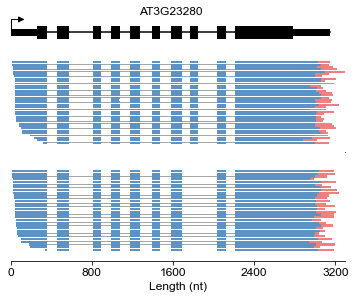

In [133]:
%%time

gene_id = 'AT3G23280'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
igv = IGV_ES(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.plot(height=2, width=6)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: user 847 ms, sys: 18.1 ms, total: 865 ms
Wall time: 905 ms


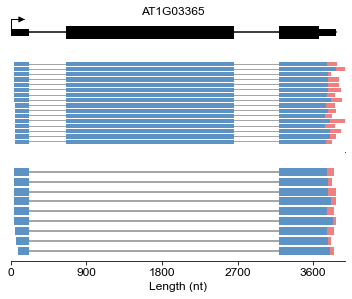

In [134]:
%%time

gene_id = 'AT1G03365'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
igv = IGV_ES(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.plot(height=2, width=6)

# IGV for APA

In [171]:
polya_cluster = '/public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.bed'
polya_cluster = pr.read_bed(polya_cluster, as_df=True)
polya_cluster['gene_id'] = polya_cluster.Name.map(lambda x: x.split('_')[0])

In [218]:
class IGV_APA(IGV):
    '''
    splice_stats_dict={
        '7630665e-c2ca-4b8d-a6d7-2240d68f8844':
            {'AT1G01010': Splice_stats(intron_total_count=5, intron_count=5, unsplice_count=0, unsplice_intron='')}，
    }
    '''
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self._get_gene_info()
        self.max = self.end
        self.min = self.start
        self.bam_list = {}
        self.bam_num = 0

    
    def add_bam(self, *bam_paths, plot_polya=False):
        '''
        Input:
            A list of bam files
            eg. add_bam('a.bam', 'b.bam')
        '''
        self.plot_polya = plot_polya
        polya_len_list = []
        for bam_path in bam_paths:
            apa_isoform = {}
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                for item in polya_cluster.query('gene_id == @self.gene_id').values:
                    apa = item[:6]
                    apa_isoform[apa[3]] = []
                
                    chrom, start, end, *_, gene_strand = apa
                    for read in inbam.fetch(self.chrom, start, end):
                        # 过滤read
                        if self._filter_reads(read):
                            continue

                        polya_len = read.get_tag('pa')
                        read_gene_id = read.get_tag('gi')
                        if read_gene_id not in {gene_id, 'None'}:
                            continue
                        
                        three_prime_end = read.reference_end if gene_strand else read.reference_start
                        if start <= three_prime_end <= end+1:
                            polya_len_list.append(polya_len)
                            apa_isoform[apa[3]].append(read)

            results = []
            for read_type in apa_isoform:
                self._sort_bam(apa_isoform[read_type], sortby='three')
                results.append(apa_isoform[read_type])
                self.bam_num += 1
            
            self.bam_list[bam_path] = results
        
        self.polya_len_threshold = self.zscore_treatment(polya_len_list)
        for bam_path in bam_paths:
            with pysam.AlignmentFile(bam_path, 'rb') as inbam:
                for read in inbam.fetch(self.chrom, start, end):
                    if polya_len < self.polya_len_threshold:
                        self._set_plot_range(read, polya_len)        


    def _plot_bam(self, ax, read_list, bam_num, read_color='#5D93C4', polya_color='lightcoral'):
        ypos = 0
        height = .4
        for read in read_list:
            if read is None:
                ypos += -int(len(read_list)*.08)
                continue

            # 画polya尾巴
            polya_len = read.get_tag('pa')
            if polya_len > self.polya_len_threshold:
                continue
            
            line = mp.Rectangle((read.reference_start, ypos-height/4), read.reference_length, height/2, color='#A6A6A6', linewidth=0)
            ax.add_patch(line)
            #read_color = read.get_tag('co')
            for block_start, block_size in self._find_exon(read):
                exon = mp.Rectangle((block_start, ypos-height), block_size, height*2, color=read_color, linewidth=0)
                ax.add_patch(exon)
            
            if self.plot_polya and polya_len > 15:
                if self.strand == '+':
                    polya_tail = mp.Rectangle((block_start+block_size, ypos-height), polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
                else:
                    polya_tail = mp.Rectangle((read.reference_start, ypos-height), -polya_len, height*2, color=polya_color, linewidth=0)
                    ax.add_patch(polya_tail)
            ypos += -1

        #step = (self.end-self.start)//400*100  # 坐标轴步长
        step = (self.max-self.min)//400*100  # 坐标轴步长

        if self.strand == '+':
            #xticks = np.arange(self.start, self.end+step, step)
            xticks = np.arange(self.start, self.max+step, step)
            ax.set_xticklabels(xticks-self.start)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
        else:
            #xticks = np.arange(self.end, self.start-step, -step)
            xticks = np.arange(self.end, self.min-step, -step)
            ax.set_xticklabels(self.end-xticks)
            ax.set_xticks(xticks)
            ax.set_xlim(self.min, self.max)
            ax.invert_xaxis()

        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_major_locator(ticker.NullLocator())
        if bam_num != self.bam_num:
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_ticks_position('none')
        else:
            ax.set_xlabel('Length (nt)')
        
        ax.set_ylim(ypos-int(len(read_list)*.1), 1+int(len(read_list)*.2))
        
    
    def plot(self, height=1, width=5):
        nrows = self.bam_num+1
        height_ratios = [.6]+[height]*self.bam_num

        fig, ax = plt.subplots(
            nrows=nrows, 
            gridspec_kw={'height_ratios': height_ratios},
            figsize=(width, sum(height_ratios)),
            sharex = True,
        )

        # plot gene_model
        self._plot_gene_model(ax[0])

        # plot bam files
        i = 1
        for bam_path in self.bam_list:
            for bam_reads in self.bam_list[bam_path]:
                self._plot_bam(ax[i], bam_reads, i)
                i += 1
        plt.subplots_adjust(hspace=0)
        plt.savefig(f'igv_plot/{self.gene_id}.APA.svg', format='svg', bbox_inches='tight')

/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/public/home/mowp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: user 2.36 s, sys: 20 ms, total: 2.38 s
Wall time: 2.37 s


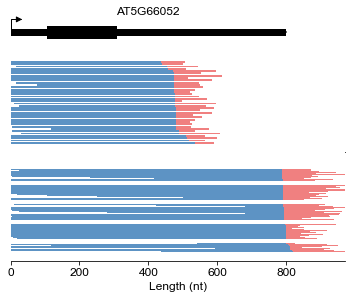

In [219]:
%%time

gene_id = 'AT5G66052'
nanopore = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'
igv = IGV_APA(gene_id)
igv.add_bam(nanopore, plot_polya=True)
igv.plot(height=2, width=6)

In [214]:
polya_cluster.query('gene_id == @gene_id')

,Chromosome,Start,End,Name,Score,Strand,ThickStart,gene_id
20569,5,26416560,26416659,AT5G66052_1,36,+,3.365,AT5G66052
20570,5,26416908,26416952,AT5G66052_2,174,+,3.605,AT5G66052
